Задание из 2-х частей.
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации - выбить auc выше 0.95
2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [1]:
import pandas as pd
import numpy as np

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation
import re

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm


In [2]:
max_words = 10000
max_len = 100
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [3]:
data = pd.read_excel('отзывы за лето.xls')

In [4]:
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


Препроцессинг

In [5]:
# exclude = set(punctuation)
# sw = set(get_stop_words("ru"))
# morpher = MorphAnalyzer()

# def preprocess_text(txt):
#     txt = str(txt)
#     txt = "".join(c for c in txt if c not in exclude)
#     txt = txt.lower()
#     txt = re.sub('https?://\S+|www\.\S+', ' ', txt)
#     txt = re.sub("\sне", "не", txt)
#     txt = re.sub(r'[^\w\s]',' ', txt)
#     txt = re.sub(r'[0-9]+', ' ', txt)
#     txt = re.sub('\n', ' ', txt)
#     txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
#     return " ".join(txt)

In [6]:
exclude = set(punctuation)
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = txt.lower()
    txt = re.sub('https?://\S+|www\.\S+', ' ', txt)
    txt = re.sub(r'[^\w\s]',' ', txt)
    txt = re.sub(r'[0-9]+', ' ', txt)
    txt = re.sub('\n', ' ', txt)
    txt = re.sub("не\s", "не", txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [7]:
data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3

In [8]:
data['target'] = data['target'].astype(int)
data.head()

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,1
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложение минус хотеть большо...,1
2,5,Отлично все,2017-08-14,отлично,1
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,зависать работа антивирус ранее пользоваться н...,1
4,5,"Очень удобно, работает быстро.",2017-08-14,удобно работать быстро,1


Разбиение на train и test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=13, stratify=data['target'])

Создадим корпус слов

In [10]:
train_corpus = ' '.join(X_train.values)
train_corpus[:100]

'классно невозможно использовать рутованный телефон работать нарекание отлично немочь понять заблокир'

Токенизация

In [11]:
import nltk
from nltk.tokenize import word_tokenize
# nltk.download("punkt")

tokens = word_tokenize(train_corpus)

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [12]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [13]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [14]:
len(tokens_filtered_top)

7848

Padding

In [15]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [16]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [17]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in X_test], dtype=np.int32)

In [18]:
x_train.shape

(15798, 100)

In [19]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, AveragePooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  
import tensorflow as tf

In [20]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_test, num_classes)

In [21]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=512, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
# model.add(AveragePooling1D())
# model.add(Conv1D(256, 5))
# model.add(Activation('relu'))
# model.add(AveragePooling1D())
model.add(Dropout(0.5))
# model.add(Conv1D(128, 3))
# model.add(Activation('relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(num_classes))

In [22]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
model.compile(loss=loss,
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
# model.summary()

In [26]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_val),
                    callbacks=[tensorboard, early_stopping])

Epoch 1/100
31/31 [==============================] - 12s 392ms/step - loss: 1.4614 - accuracy: 0.8227 - val_loss: 1.1094 - val_accuracy: 0.8468
Epoch 2/100
31/31 [==============================] - 12s 387ms/step - loss: 0.8995 - accuracy: 0.8500 - val_loss: 0.6923 - val_accuracy: 0.8613
Epoch 3/100
31/31 [==============================] - 14s 440ms/step - loss: 0.5419 - accuracy: 0.8913 - val_loss: 0.4405 - val_accuracy: 0.8982
Epoch 4/100
31/31 [==============================] - 15s 495ms/step - loss: 0.3581 - accuracy: 0.9140 - val_loss: 0.3151 - val_accuracy: 0.9137
Epoch 5/100
31/31 [==============================] - 15s 492ms/step - loss: 0.2637 - accuracy: 0.9265 - val_loss: 0.2558 - val_accuracy: 0.9170
Epoch 6/100
31/31 [==============================] - 15s 492ms/step - loss: 0.2107 - accuracy: 0.9361 - val_loss: 0.2313 - val_accuracy: 0.9195
Epoch 7/100
31/31 [==============================] - 15s 493ms/step - loss: 0.1783 - accuracy: 0.9423 - val_loss: 0.2065 - val_accuracy:

In [27]:
score = model.evaluate(x_test, y_val, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 1s 109ms/step - loss: 0.1985 - accuracy: 0.9337


Test score: 0.19849103689193726
Test accuracy: 0.9336708784103394


In [28]:
%load_ext tensorboard

In [29]:
# %tensorboard --logdir logs

### Теперь инициализируем веса эмбеддингами word2vec

In [30]:
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count

In [31]:
corpus = []
for i in ([[sentence] for sentence in data.text.tolist()]):
    corpus.append(i[0].split())

In [32]:
corpus[:5]

[['it', 'just', 'works'],
 ['целое',
  'удобноной',
  'приложение',
  'минус',
  'хотеть',
  'большой',
  'доступ',
  'персональный',
  'данные',
  'телефонеприходиться',
  'пользоваться',
  'ограниченный',
  'режим'],
 ['отлично'],
 ['зависать', 'работа', 'антивирус', 'ранее', 'пользоваться', 'нормальный'],
 ['удобно', 'работать', 'быстро']]

обучим модель

In [33]:
model = Word2Vec(corpus, min_count = 5, workers=cpu_count())

In [34]:
model.wv.similar_by_word('антивирус')

[('ругаться', 0.9989317059516907),
 ('оригинальный', 0.9989053010940552),
 ('удалить', 0.9989050626754761),
 ('вирус', 0.9988026022911072),
 ('официальный', 0.9986897706985474),
 ('ограничивать', 0.9985355138778687),
 ('flyme', 0.9985214471817017),
 ('ограниченный', 0.9985068440437317),
 ('дело', 0.9984753727912903),
 ('какой', 0.9983959197998047)]

In [35]:
model.wv['антивирус'], model.wv['антивирус'].shape

(array([-0.24666245, -0.29427359,  1.1640195 , -0.35590628,  0.08959463,
        -0.06074868,  0.2708067 , -0.63072306, -0.29963046, -0.38810402,
        -0.09133121, -0.18076327, -0.09672618, -0.49944746, -0.26514196,
         0.47905618,  0.23496138, -0.38501805,  0.32604495,  0.3532129 ,
         0.25291225,  0.47595406,  0.27749506,  0.58282524,  0.4340875 ,
        -0.7930976 ,  0.5486658 , -0.30772156, -0.7523607 , -0.14823994,
         0.30487442, -0.78327256,  0.5146738 ,  0.10380322,  0.736226  ,
        -0.02341006,  0.39234743, -0.08682327, -0.154586  ,  0.629389  ,
         0.05748975, -0.7566305 ,  0.14445017,  0.04314176, -0.28453663,
         0.35770237, -0.563023  , -0.02208195,  0.56017387, -0.46296582,
         0.07374523, -0.12184202,  0.03357354,  0.6002179 ,  0.41554528,
         0.4555081 , -0.3877102 ,  0.07124478,  0.3783358 ,  0.55914474,
        -0.21715112, -0.2690043 ,  0.06362831, -0.315315  , -0.37002084,
         0.15431792, -0.14874032, -0.4924782 , -0.6

Итак, у нас есть эмбеддинги для каждого слова в корпусе размером (100,).  
Попробуем их сложить и получить матрицу, которую потом отправим в 

In [36]:
def summ_ebm(txt):
    summ_ = np.zeros(100)
    for word in txt.split():
        if word in model.wv:
            summ_ += model.wv[word]
    return summ_

In [37]:
X_train_emb = pd.DataFrame(X_train)
X_test_emb = pd.DataFrame(X_test)

In [38]:
X_train_emb['sum_emb'] = X_train_emb.text.apply(summ_ebm)
X_test_emb['sum_emb'] = X_test_emb.text.apply(summ_ebm)

In [39]:
X_train_emb.head(2)

,text,sum_emb
547,классно,"[-0.07384242862462997, -0.047830261290073395, ..."
1863,невозможно использовать рутованный телефон,"[-0.6854145713150501, -0.6538085974752903, 3.0..."


In [40]:
xtrain_emb = np.zeros((X_train_emb.shape[0], 100))
xtest_emb = np.zeros((X_train_emb.shape[0], 100))

In [42]:
for i in tqdm(range(X_train_emb.shape[0])):
    xtrain_emb[i] = X_train_emb.iloc[i].sum_emb

In [43]:
xtrain_emb.shape

(15798, 100)

In [44]:
for i in tqdm(range(X_test_emb.shape[0])):
    xtest_emb[i] = X_test_emb.iloc[i].sum_emb

Итак мы получили матрицы из сумм эмбеддингов каждого слова в каждом отзыве. Попробуем засунуть теперь это в нейросеть

In [45]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_test, num_classes)

In [60]:
model = Sequential()
model.add(Input(shape=(xtrain_emb.shape[0], xtrain_emb.shape[1])))
# model.add(Embedding(input_dim=max_words, output_dim=512, input_length=max_len))
model.add(Conv1D(128, 3)),
model.add(Activation("relu"))
# model.add(AveragePooling1D())
# model.add(Conv1D(256, 5))
# model.add(Activation('relu'))
# model.add(AveragePooling1D())
model.add(Dropout(0.5))
# model.add(Conv1D(128, 3))
# model.add(Activation('relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(num_classes))

In [61]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [62]:
model.compile(loss=loss,
              optimizer='adam',
              metrics=['accuracy'])

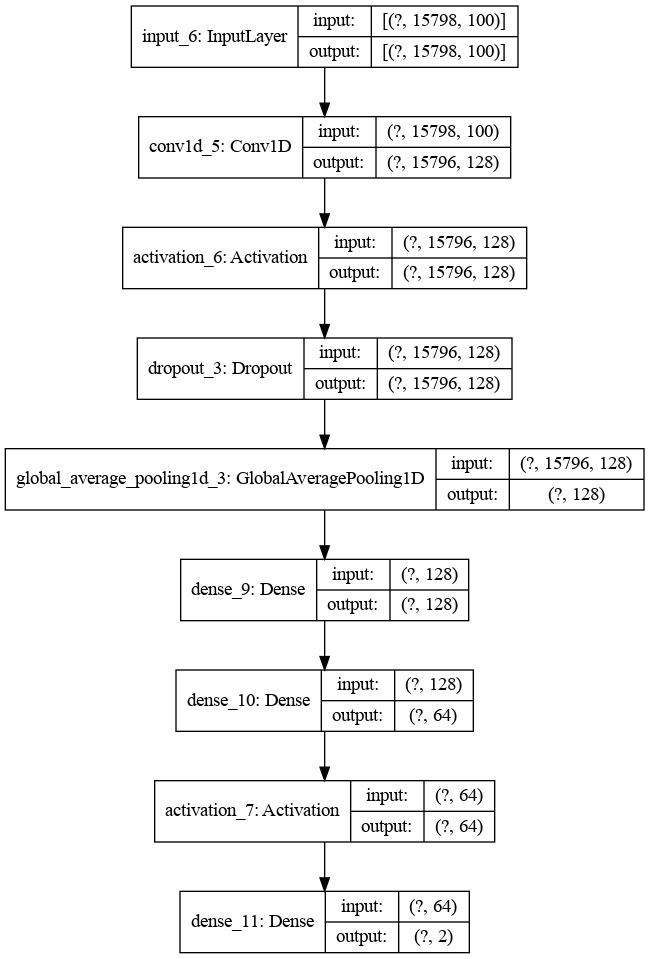

In [63]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [64]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)  


history = model.fit(xtrain_emb, y_train,
                    batch_size=batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(xtest_emb, y_val),
                    callbacks=[tensorboard, early_stopping])

Epoch 1/100


ValueError: in user code:

    /home/ssv/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/ssv/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ssv/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ssv/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ssv/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/ssv/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/ssv/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 100]
